# <center> EPE </center> #

Lorenz Energy Cycle formulation see, e.g. von Storch et al 2012 JPO42, 2185-2205.

EPE is then g' T'^2/dT*/dz
with T* being time mean and area-mean (potential) Temperature. You cannot relate any T' scaling with Eq. 28. I suggest you recalculate a measure for T'

\begin{equation}
EPE = g' T' ^{2} \frac{d T^* }{dz}
\end{equation}

\begin{equation}
EPE = g \frac{T_z}{T} T'^2 \frac{d<\overline{T}> }{dz}
\end{equation}

\begin{equation}
EPE =  \frac{T'^2}{2N^2} 
\end{equation}

In [2]:
# Some parameters
VAR = 'Psi'  # Pick what plot
Full = 'Extremes'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'PSI.nc'

Qplot = 'Y'

In [3]:
# Load in Modules
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.ma as ma
import sys
import cmocean
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from HB_Plot import nf, fmt
import SG
import useful as hb
import layers_calc_numba
import APE_Calc as AC
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/VSQT.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

In [4]:
fname = x+'/3daynokpp/'
c = utils.ChannelSetup(output_dir=str(fname))

/noc/users/hb1g13/.conda/envs/CentOS/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide


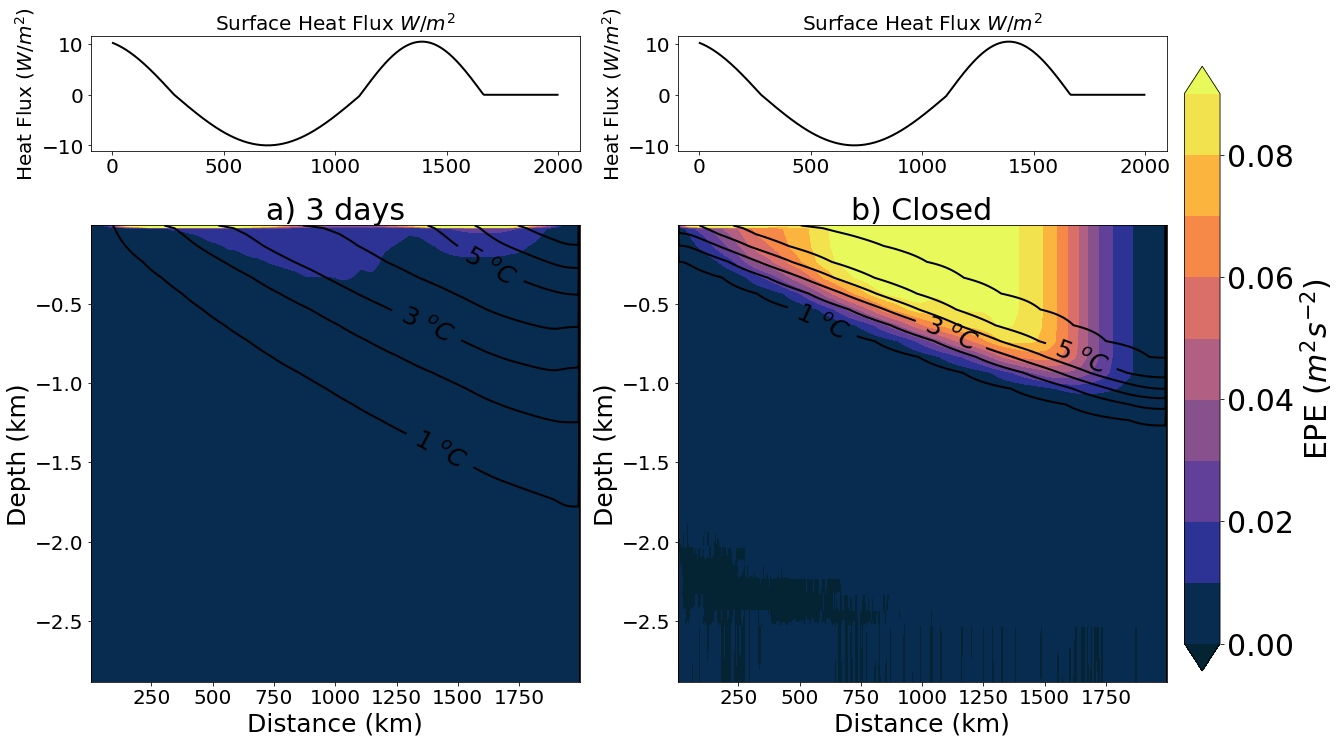

In [21]:
fig = plt.figure(figsize=(16.5, 10.5))
# Create Panels
EKEt = []
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 4])
ax = plt.subplot(gs[0])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    CellVol = np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    # PLOT PANNELS
    EKE = c.calc_EKE()
    Tpsq =c.mnc('VSQT.nc','THETASQ', mask=c.HFacC[:]) - c.mnc('TavT.nc','THETA',
                                                      mask=c.HFacC[:])**2
   
    T = c.mnc('TavT.nc','THETA')
    Tz = c.ddz_cgrid_centered(T)
    Tstar  = c.mnc('TavT.nc','THETA').mean(axis=2).mean(axis=1)
    Tstar = np.tile(Tstar,(c.Nx,c.Ny,1)).T
    T  = c.mnc('TavT.nc','THETA')
    g = -9.81  
    EPE = g * (Tz/T)*Tpsq*c.ddz_cgrid_centered(Tstar)
    if str(tau[Runs[i]]) == 'Closed':
        EPE = 0.1*EPE
    EPE = np.cumsum((EPE).mean(axis=2)[::-1],axis=0)[::-1]
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1, 8, 1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    -EPE*10**3, Psi_levs, cmap=cmocean.cm.thermal, extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc', 'THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs,
                   colors='k', linewidths=2)

    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' days', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax,ticks=Psi_ticks)
cbar.ax.set_ylabel(r'EPE $(m^2s^{-2})$', fontsize=30, )
#cbar.ax.set_ylabel(r'EPE $(m^2s^{-2})$ $g \frac{T_z}{T} \frac{\overline{ v^{\prime} T^{\prime }}}{\sqrt{v^{\prime 2}}} \frac{d<\overline{T}> }{dz}$', fontsize=30, )
#cbar.ax.tick_params(labelsize=30)
cbar.ax.tick_params(labelsize=30)

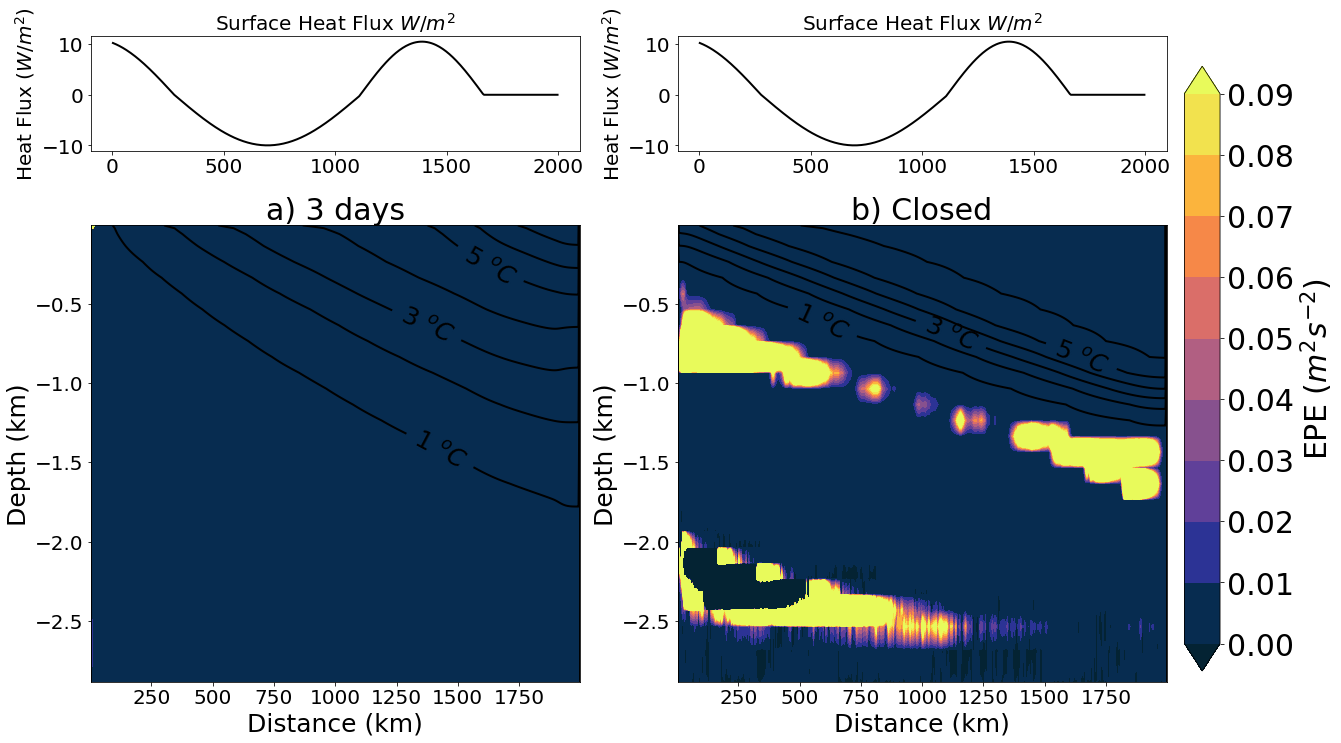

In [22]:
fig = plt.figure(figsize=(16.5, 10.5))
# Create Panels
EKEt = []
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 4])
ax = plt.subplot(gs[0])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    CellVol = 5000**2*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    # PLOT PANNELS
    EKE = c.calc_EKE()
    Tpsq =c.mnc('VSQT.nc','THETASQ', mask=c.HFacC[:]) - c.mnc('TavT.nc','THETA',
                                                      mask=c.HFacC[:])**2
   
    T = c.mnc('TavT.nc','THETA')
    Tz = c.ddz_cgrid_centered(T)
    EPE = Tpsq/Tz**2
    if str(tau[Runs[i]]) == 'Closed':
        EPE = 0.1*EPE
    EPE = (EPE/CellVol).mean(axis=2)
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1, 8, 1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    EPE,Psi_levs, cmap=cmocean.cm.thermal, extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc', 'THETA')
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        Tavlat = np.apply_along_axis(np.divide, 0, Tavlat, 4-np.sum(tRef*c.dzf)/-c.zc[-1])
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs,
                   colors='k', linewidths=2)

    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' days', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)
cbar.ax.set_ylabel(r'EPE $(m^2s^{-2})$', fontsize=30, )
#cbar.ax.set_ylabel(r'EPE $(m^2s^{-2})$ $g \frac{T_z}{T} \frac{\overline{ v^{\prime} T^{\prime }}}{\sqrt{v^{\prime 2}}} \frac{d<\overline{T}> }{dz}$', fontsize=30, )
#cbar.ax.tick_params(labelsize=30)
cbar.ax.tick_params(labelsize=30)